# Learn Reinforcement Learning Basics with Multi-armed Bandits

Humans learn from experience everyday. From finding the fastest route to work or cooking your favourite meal, experience tells us where we can improve our performance. Computers can learn in a similar framework known as _reinforcement learning_. 

One example of reinforcement learning is state-of-the-art computer chess programs. DeepMind built the computer program [AlphaZero](https://en.wikipedia.org/wiki/AlphaZero) to play chess through reinforcement learning by making it play against itself over and over. In each game a reward is given to the program for winning and nothing is given for losing. AlphaZero observed what moves lead to winning positions, what moves lead to losses and learned how to play to maximise its expected returns. AlphaZero is one of the strongest chess computers today and is much stronger than any human player. Top grandmasters today consult programs like AlphaZero to prepare for tournaments and [find moves humans would struggle to see](https://www.youtube.com/watch?v=z2g3dRZP3yI).

__Aims__. We begin more modestly with the intriguingly named mutli-armed bandit problem as a way of introducing fundamental concepts in reinforcement learning. We will learn:
 - What is the exploration-exploitation trade-off?
 - How to implement $\varepsilon$-greedy algorithms and their variants.
 - How to generalise $\varepsilon$-greedy algorithms to non-stationary problems using weighted-averages.

__Resources__. Companion code can be found on GITHUB. The content of the article is based on chapter 2 of _Reinforcement Learning_ by Sutton and Barto, 2018 and I direct the reader there for more details on the multi-armed bandit problem.

<font color='0789DF'>Table of contents<font><a class='anchor' id='top'></a>
- [The problem of multiarmed bandits](#problemMAB)
- [A first try: $\varepsilon$-greedy algorithms](#firsttry)
- [Optimistic initial values](#OIV)
- [Implementing $\varepsilon$-greedy algorithms with decay](#decay)
- [Upper-confidence-bound action selection](#UCB)
- [Non-stationary bandits](#nonstat)
- [Beyond bandits](#Beyondbandits)
- [Summary](#Summary)
- [Further reading](#FurtherReading)

## The problem of multi-armed bandits <a class="anchor" id="problemMAB">
    
A _one-armed bandit_ is a machine at a casino where a player pulls a lever (or _bandit_) and a random reward is given. In the _multi-armed bandit problem_ one imagines a machine with $k$ bandits and the player must choose which to pull in order to maximise the expected reward. The issue is that the player has no information about the distribution of reward given on each pull and can only learn about the reward distribution of each bandit by playing and observing the random reward that a bandit gives.
    
_What strategy maximises the expected return in the multi-armed bandit problem?_
    
It was discovered by Allied scientists in World War II that the multi-armed bandit problems is highly nontrivial. Gittens in the seminal paper _Bandit Processes and Dynamic Allocation Indices_ quipped "... efforts to solve it so sapped the energies and minds of Allied analysts that the suggestion was made that the problem be dropped over Germany, as the ultimate instrument of intellectual sabotage."
    
__Assumptions__. In order to provide a meangingful answer to the multi-armed bandit problem we assume that the reward distribution of each bandit does not depend on how many times it has been pulled and is independent of every other bandit. To be precise, at each time step $t=1,2,\ldots$ we choose from the $k$ bandits according to some rule. We recieve a random reward at time $t$ that will update our selection rule at time $t+1$. The question is, what is a good selection rule?
    
Our selection at each time step will be informed by two principles:
 - _Exploration_: We should try each bandit numerous times for an empirical estimate on what the expected return of that bandit is.
 - _Exploitation_: We should choose the bandit that we estimate has the highest expected return.
    
__How do we balance between exploration and exploitation?__ This problem is at the heart of reinforcement learning and the multi-armed bandit problem offers a good example in which to explore it first.

## A first try: $\varepsilon$-greedy algorithms <a class="anchor" id="firsttry">
    
In order to describe our first algorithm we need to introduce some definitions.

__Actions and value functions__. At each time step $t=1,2,\ldots$ we select an action $A_t\in\{1,2,\ldots,k\}$ that corresponds to the choice of bandit. Given an action $A_t$ the corresponding reward is written as $R_t$. The _value_ of the action $A_t$ is defined to be the expected reward given the action $A_t$ is selected. The _value function_ $q_*$ maps actions to the expected reward given that action is selected so that for $a\in\{1,2,\ldots,k\}$ we have

$$
    q_*(a) = \mathbb{E}\left[ R_t | A_t=a \right].
$$

__Sample-averages__. As we do not know the value function when making our decisions we instead approximate it by taking a sample-average. That is, we introduce the function

$$
    Q_t(a) = \frac{\sum_{i=1}^{t-1}R_t\mathbb{1}_{\{A_t=a\}}}{\sum_{i=1}^{t-1}\mathbb{1}_{\{A_t=a\}}}
$$

that computes the average return for the action $a\in\{1,2,\ldots,k\}$ before time $t$. Here, for an event $B$, we have $\mathbb{1}_B$ is the _indicator function_ for the event $B$ so that
    
$$
    \mathbb{1}_B = \begin{cases}1 & \text{ if }B\text{ occurs},\\
    0 & \text{ otherwise}.\end{cases}
$$

<div class="alert alert-block alert-warning">  
<b>Remark:</b> We set $Q_t(a)$ to be a given finite value if $\sum_{i=1}^{t-1}\mathbb{1}_{\{A_t=a\}}=0$ to avoid an issue of dividing by zero.  
</div>

__Why sample-averages are useful__. Our hope is that $Q_t(a)$ is a good approximation for $q_*(a)$ for $t$ large enough. Indeed, by the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers), so long as the action $a$ is selected infinitely many times, then $Q_t(a)$ converges to $q_*(a)$ as $t$ tends to infinity. Hence as long as exploration is maintained, the sample-averages offer a good approximation for the expected reward for each bandit for $t$ large.
    
    
__Greedy action-selection__. A _greedy_ choice at time $t$ selects the action with the highest value under $Q_t$ so that

$$
    A_t = \text{argmax}_a Q_t(a)
$$

with ties broken by an arbitrary rule. Note that the sample-average $Q_t$ provides empirical evidence for the quality of each bandit but there is uncertaintity in this estimation. If the action at each step is chosen by the greedy choice then we are not sufficiently exploring the bandits. To maintain exploration, at each step we have a small probability $\varepsilon$ to choose a bandit uniformly at random as our action and with probability $1-\varepsilon$ the action is the greedy choice. We refer to this as an $\varepsilon$_-greedy algorithm_.
    
__A practical example__. Consider the multi-armed bandit problem with ten bandits whose rewards are distributed as normal random variables with mean $q_i$ for $i\in\{1,2,\ldots 10\}$ and variance 1 where $q_i$ is distributed as a normal random variable with mean 0 and variance 1. Below we plot the average returns and ratio of selecting the optimal bandit for three different versions of the $\varepsilon$-greedy algorithm.

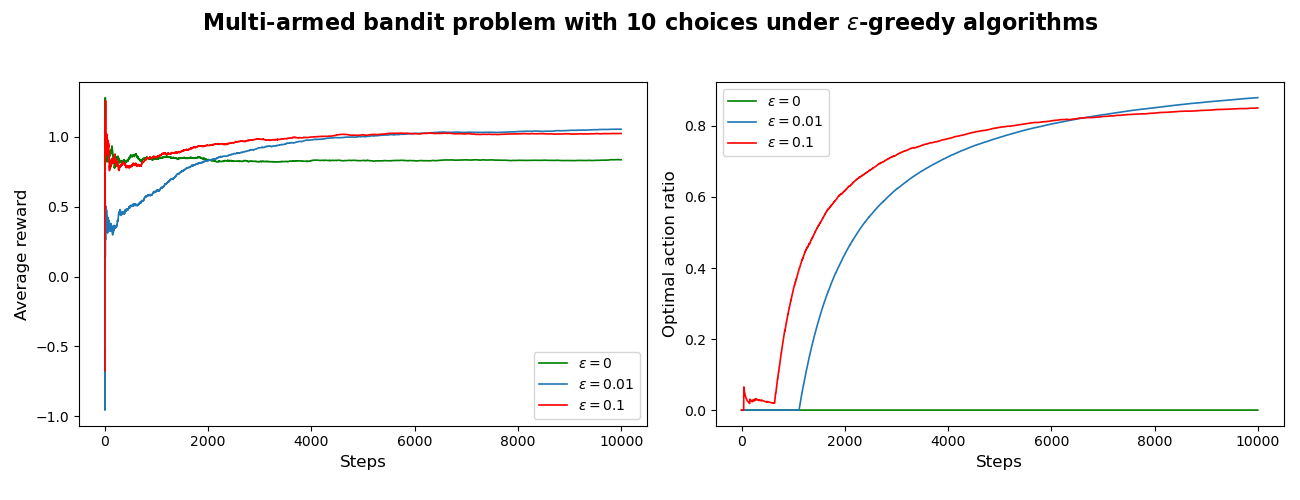

__The greedy $\varepsilon=0$ (green)__: In the plot above, green corresponds to the purely greedy choice in action selection. In the early steps we find a bandit that has a positive expected return and choose this bandit many times. We do not sufficiently explore the bandits and in fact never sample from the optimal bandit! 

__The exploring $\varepsilon=0.1$ (red)__: Slightly better is the red plot in which $\varepsilon=0.1$. We explore among the bandits and rapidly discover the optimal bandit as the sample-averages converge to the true value function by the law of large numbers. Unfortunately our average reward suffers from the continued exploration long after we are confident about which bandit is the best choice.

__In between with $\varepsilon=0.01$ (blue)__: Exploration is slower but surpasses the average reward for $\varepsilon=0.1$ at around 7000 steps. While we take longer to converge to the true action values, we select from the optimal bandit more regularly in the long run.

## Optimistic initial values <a class="anchor" id="OIV">
    
The main downside to $\varepsilon$-greedy algorithms is that at each bandit has probability at least $\varepsilon/k$ at each step of being selected, regardless of the sample-average $Q_t$ we have estimated for that bandit. How do we stop selecting bandits with low expected return while also maintaining exploration?
    
One method to circumvent the issue of maintaining exploration is _optimistic initial values_ (OIV). Under OIV the sample-average of each bandit is initially set to be a large value and at each step a greedy choice is made with ties broken arbitrarily. Exploration is initially encourages as bandits that have not been tried many times will be selected while the sample-average function $Q_t$ will still converge to the action-value function $q_*$ whence exploitation will then dominate. 
    
__Example with OIV__. Consider the same bandit problem as in the previous example with ten bandits whose rewards a normal random variables with variance 1 and mean given by a standard normal random variable. Compare the performance of $\varepsilon$-greedy algorithms against an implementation of OIV with initial value given by 6 that is greedy henceforth.

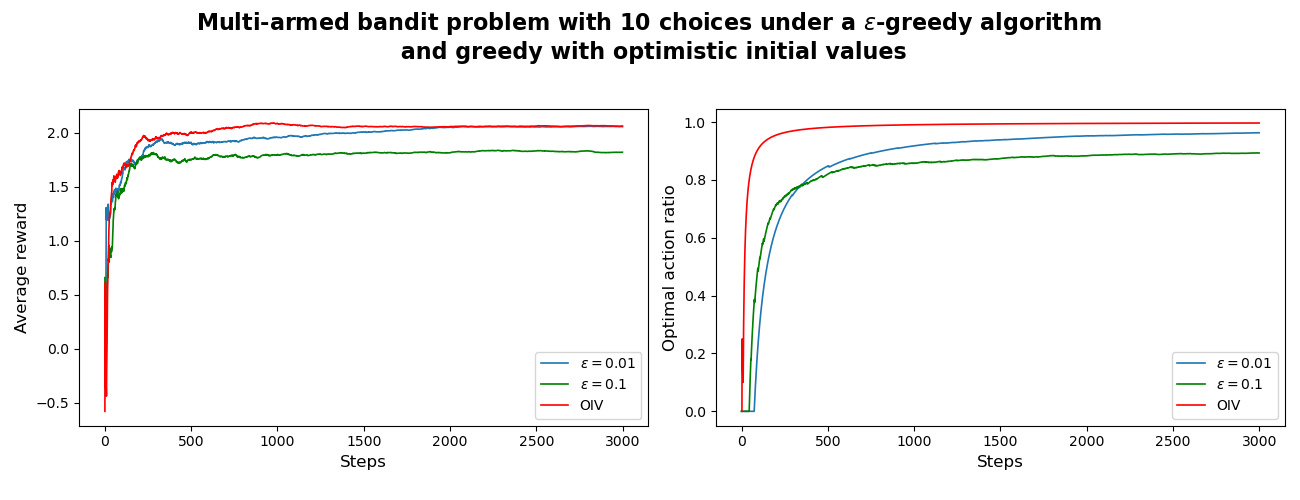

<div class="alert alert-block alert-danger">  
<b>Warning:</b> If you run the code provided then you may see plots that look starkly different to the one above. The randomness in the true action values and the initial samples can dramatically alter the average reward and optimal action ratio plots for both the $\varepsilon$-greedy algorithms and greedy with optimistic initial values. Nevertheless the above plot is illustrative in how you want the optimistic intitial values to improve upon $\varepsilon$-greedy algorithms.
</div>

## Implementing $\varepsilon$-greedy algorithms with decay <a class="anchor" id="decay">

A natural heuristic in the exploration-exploitation balance is that we encourage exploaration at the start and prefer exploitation once we have more information about the sample-average function $Q_t$. Our heuristic can be implemented by setting $\varepsilon$ to be a function of time and not a constant value. For example we can set

$$
    \varepsilon(t) = \frac{1}{\sqrt{t}}
$$

and follow a $\varepsilon$-greedy algorithm as above. By setting $\varepsilon$ to decay over time, exploration is increasingly penalised in time allowing for exploitation of the bandits with large expected returns.
    
__How should we set $\varepsilon$ to decay over time?__ If you want every state to be visited infinitely often to maintain exploration, then $\varepsilon$ should not decay too fast in time. Setting the decay rate is a subtle issue and requires the application of the [_Borel-Cantelli lemma_](https://en.wikipedia.org/wiki/Borel%E2%80%93Cantelli_lemma) from probability theory to provide a good criterion. For our purposes a decay rate of $\varepsilon(t) = \tfrac{1}{\sqrt{t}}$ works. The interested reader should consider that if 

$$
    \sum_{i=1}^\infty\varepsilon(i) = \infty
$$
    
then non-greedy actions will be selected only finitely many times. In this case, after a certain time, only greedy actions would be selected.
    
__Example with decay__. Below we consider the same multiarmed bandit problem with a $\varepsilon$-greedy algorithm with $\varepsilon=0.1$ and an $\varepsilon$-greedy algorithm with decay where we initially set $\varepsilon=0.1$. Observe how the decay rate increases our ability to exploit bandits with high expected return while being able to explore in the initial stages.

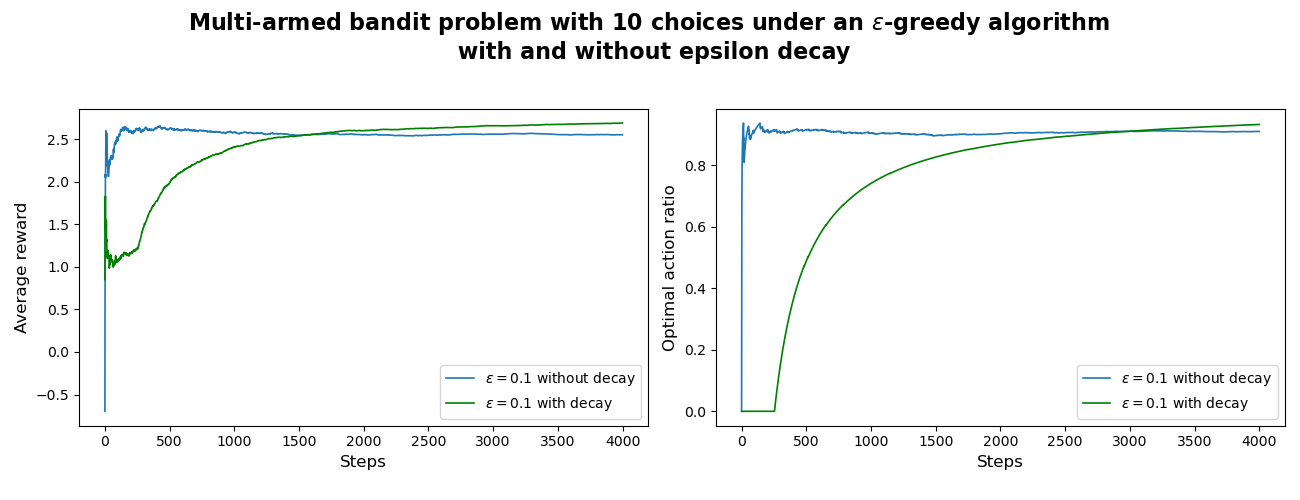

## Upper-confidence-bound action selection <a class="anchor" id="UCB">

Recall that $\varepsilon$-greedy algorithms have an $\varepsilon$ probability of choosing the next action uniformly at random. Rather than selecting the choice uniformly at random, it would be more appropriate to choose the next action in a manner that considers the sample-average $Q_t$ so that actions with a higher sample-average are more likely to be selected. _Upper-confidence-bound_ (UCB) action selection is one manner of implementing this idea.

Fix a constant $c>0$ and suppose we choose the action at time $t$ to be

$$
    A_t = \text{argmax}_a \left( Q_t(a) + c\sqrt{\frac{\ln(t)}{N_t(a)}} \right)
$$

where $N_t(a)$ is the number of times the action $a$ has been chosen by time $t$. The constant $c$ is a [_hyperparameter_](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) that will need to be tuned to the problem at hand. 

<div class="alert alert-block alert-warning">  
<b>Remark:</b> If $N_t(a)=0$ then one option is to take the convention that $a$ is a maximising action to avoid issues of dividing by zero in UCB action selection. Another approach to avoid division by zero is to implement UCB  action selection as 
$$
    A_t = \text{argmax}_a \left( Q_t(a) + c\sqrt{\frac{\ln(t)}{N_t(a)+10^{-6}}} \right)
$$
and we use this approach in our practical example.
</div>

Consider how UCB action selection balances exploitation and exploration. If $Q_t(a)$ is large then the action will be preferred as we estimate the expected return under the action $a$ to be large. If $N_t(a)$ is small then the right-hand term in the UCB action choise is large and the action $a$ is preferred as we consider it to be underexplored. 
    
__Example with UCB__. Below we compare UCB with $c=2$ and a $\varepsilon$-greedy algorithm with $\varepsilon=0.1$ on our multi-armed bandit problem. In this case UCB performs best. 

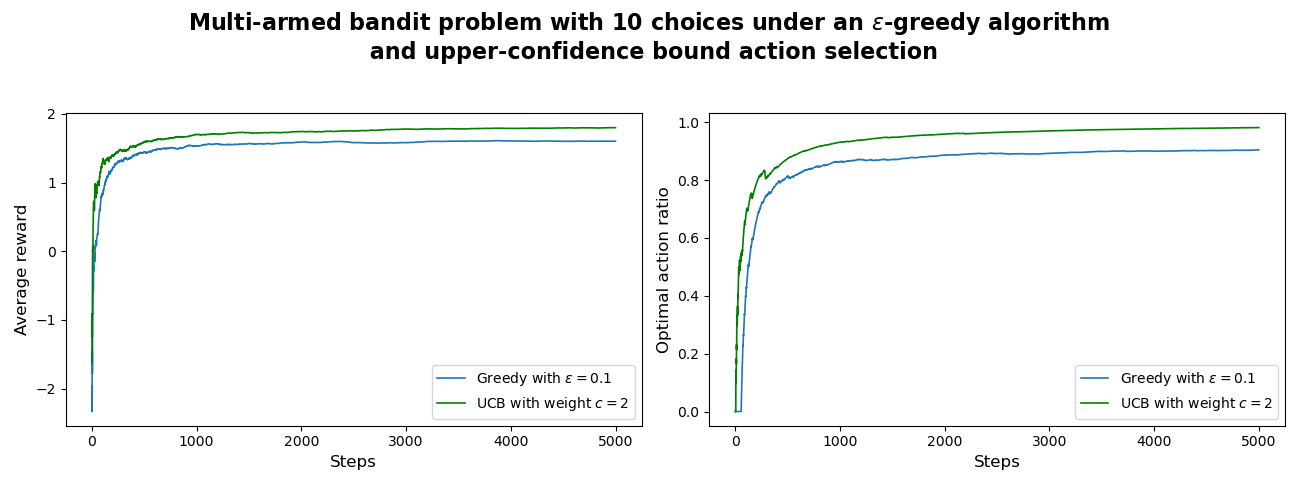

## Non-stationary bandits <a class="anchor" id="nonstat">

The analysis of the multi-armed bandit problem considered until now has assumed that the reward distribution associated to each bandit does not change over time. Such an assumption is called _stationarity_.

Suppose that an unscrupulous casino owner demanded that the labels of the bandits be swapped at random times. That is, at each step there is a small probability that two bandits are chosen at random and their reward distributions are swapped.

Our strategies thus far used a sample-average to estimate the quality of a bandit. In the swapping example, sample-averages will perform poorly because it is the sample-average over potentially many distributions and we do not know which distribution corresponds to which bandit!

In order to tackle non-stationary bandits we replace sample-averages with _weighted-averages_.

__Weighted-average__. The idea of a weighted-average is to give higher weighting to more recent rewards. More precisely, given an action $A_n=a$ we implement the update rule

$$
    Q_{n+1}(a) = Q_n(a) + \alpha (R_n - Q_n(a))
$$

where $\alpha>0$ is a parameter known as the _step-size_ and $Q_1(a)$ is an initial estimate.

To see why this update rule acts as a weighted average, observe, with suppression on the dependence on the action, that

\begin{align*}
    Q_{n+1} &= Q_n + \alpha (R_n - Q_n)\\
    &= \alpha R_n + (1-\alpha)Q_n\\
    &= \alpha R_n + (1-\alpha)\left(Q_{n-1} + \alpha (R_{n-1} - Q_{n-1}) \right)\\
    &= \ldots\\
    &= (1-\alpha)^n Q_1 + \sum_{i=1}^n \alpha(1-\alpha)^{n-i}R_i.
\end{align*}

Thus the weighting given to the initial estimate $Q_1$ is decaying exponentially and the greatest weighting is given to the most recent rewards. This rule is often called _exponential-recency weighted average_.

__Intuition__. The idea behind the weighted-average is that our action-selection has a _memory_ that forgets rewards that occured long in the past. As we are non-stationary, the environment may change at each time step and more recent rewards provide a better estimate for the current optimal action. 
    
__A non-stationary example__. Consider the non-stationary multi-armed bandit problem with an $\varepsilon$-greedy algorithm that uses sample-averages versus an $\varepsilon$-greedy algorithm that uses weighted-averages with step-size $\alpha=0.1$. Fix the swap probability $s=0.05$. Observe that the weighted-average algorithm maintains a much higher average reward as it can exploit recent estimates for the best bandit before the best bandit changes again.

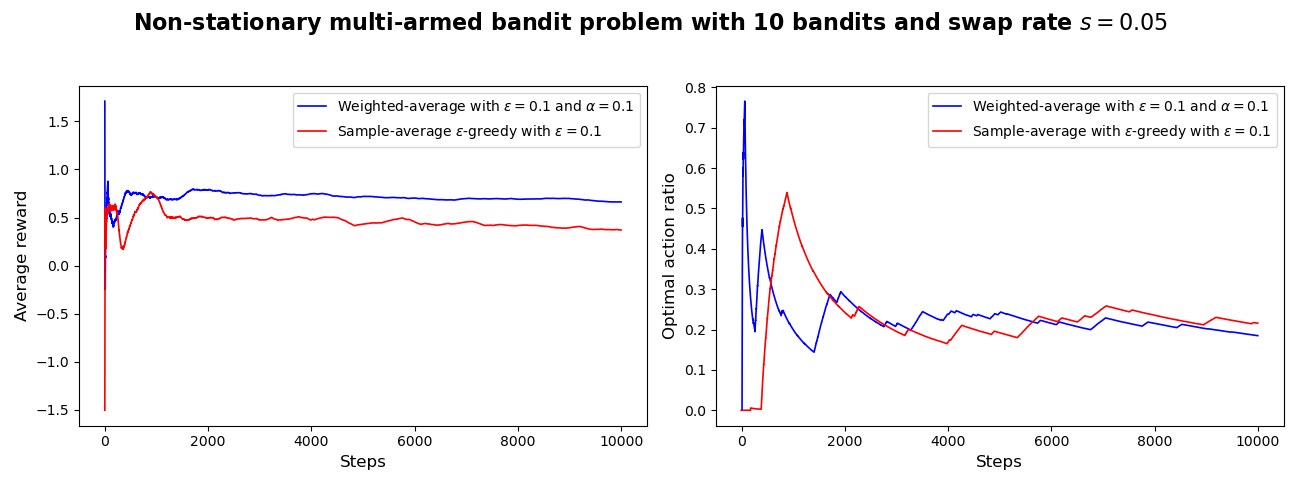

__Sample-averages revisited__. The alert reader will note that if we let the step-size $\alpha=\alpha_n$ depend on time and choose $\alpha_n=\tfrac{1}{n}$ then we recover the sample-average function used in the stationary multi-armed bandit problem. More generally, convergence of $Q_t$ to the value-function $q_*$ is ensured if the step-size parameter $\alpha_n$ satisfies for each action $a$

$$
    \sum_{i=1}^{\infty}\alpha_n(a) = \infty \quad \text{and} \quad \sum_{i=1}^{\infty}\alpha_n(a)^2 < \infty.
$$

These two conditions balance the step-size as follows. The first condition requires that the step-sizes are large enough to explore our choices regardless of the initial conditions or the inherent randomness. The second condition requires that the step-sizes are small enough so that there is convergence to the value-function $q_*$.

The constant step-size parameter choice in the non-stationary setting satisfies the first condition but not the second meaning that we do not converge. In the non-stationary setting this is exactly what we want as the rewards are changing in time and convergence would not occur in any case. We choose according to estimates from the most recent rewards that approximate our current belief about what choice is the best knowing that the distribution will vary in time.

## Beyond bandits <a class="anchor" id="Beyondbandits">
    
The multi-armed bandit problem has the same choice to make at each time step. Even in the non-stationary setting, the choice is still between which of the $k$ bandits to choose from. More generally, reinforcement learning problems will have _states_ as well as actions, requiring the need to evaluate _state-action_ pairs.
    
Returning to chess, a state could be a configuration of pieces on an 8x8 board. The actions will be all possible legal moves. This is much harder! The total number of possible chess configurations is unimaginably massive. How could a computer decide what the best moves are in _any_ given position? How can a computer decide what to do in a position it has never seen before?
    
Answering these questions is beyond the scope of the article and require much more powerful techniques. Hopefully this article sparks an interest in the reader in finding out more about reinforcement learning!

## Further Reading <a class="anchor" id="FurtherReading">
    
 - _Reinforcement Learning_, Sutton and Barto, 2018. Chapter 2 is dedicated to the problem of multi-armed bandits.
 - _Artifical Intelligence_, Russell and Norvig, 2010. Page 841 has a discussion on the multi-armed bandit problem.
 - [Wikipedia article on multi-armed bandits](https://en.wikipedia.org/wiki/Multi-armed_bandit)